In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import eurostat
import matplotlib.pyplot as plt
import os

plt.style.use("ggplot")

%load_ext jupyter_black

# Efficiency data

## Eurostat data

### Download data

In [2]:
# df = eurostat.get_toc_df() does not work anymore
# df.head()

In [3]:
dataset_code = "NRG_BAL_C"
# df[df.code == dataset_code]

In [4]:
list_parameters = eurostat.get_pars(dataset_code)
list_parameters

['freq', 'nrg_bal', 'siec', 'unit', 'geo']

In [5]:
dict_of_dict = {}
for parameter in list_parameters[0:]:
    print(parameter)
    list_values = eurostat.get_par_values(dataset_code, parameter)

    print(list_values)

freq
['A']
nrg_bal
['PPRD', 'RCV_RCY', 'IMP', 'EXP', 'STK_CHG', 'GAE', 'INTMARB', 'GIC', 'INTAVI', 'NRGSUP', 'GIC2020-2030', 'PEC2020-2030', 'FEC2020-2030', 'TI_E', 'TI_EHG_E', 'TI_EHG_MAPE_E', 'TI_EHG_MAPCHP_E', 'TI_EHG_MAPH_E', 'TI_EHG_APE_E', 'TI_EHG_APCHP_E', 'TI_EHG_APH_E', 'TI_EHG_EDHP', 'TI_EHG_EB', 'TI_EHG_EPS', 'TI_EHG_DHEP', 'TI_EHG_CB', 'TI_CO_E', 'TI_BF_E', 'TI_GW_E', 'TI_RPI_E', 'TI_RPI_RI_E', 'TI_RPI_BPI_E', 'TI_RPI_PT_E', 'TI_RPI_IT_E', 'TI_RPI_DU_E', 'TI_RPI_PII_E', 'TI_PF_E', 'TI_BKBPB_E', 'TI_CL_E', 'TI_BNG_E', 'TI_LBB_E', 'TI_CPP_E', 'TI_GTL_E', 'TI_NSP_E', 'TO', 'TO_EHG', 'TO_EHG_MAPE', 'TO_EHG_MAPCHP', 'TO_EHG_MAPH', 'TO_EHG_APE', 'TO_EHG_APCHP', 'TO_EHG_APH', 'TO_EHG_EDHP', 'TO_EHG_EB', 'TO_EHG_PH', 'TO_EHG_OTH', 'TO_CO', 'TO_BF', 'TO_GW', 'TO_RPI', 'TO_RPI_RO', 'TO_RPI_BKFLOW', 'TO_RPI_PT', 'TO_RPI_IT', 'TO_RPI_PPR', 'TO_RPI_PIR', 'TO_PF', 'TO_BKBPB', 'TO_CL', 'TO_BNG', 'TO_LBB', 'TO_CPP', 'TO_GTL', 'TO_NSP', 'NRG_E', 'NRG_EHG_E', 'NRG_CM_E', 'NRG_OIL_NG_E', 'NRG

In [6]:
# New with all year
dataset_code = "NRG_BAL_C"

# Download dictionary to rename columns with explicit names
dict_siec = eurostat.get_dic(dataset_code, "siec")
dict_siec = {key: value for (key, value) in dict_siec}

dict_nrg_bal = eurostat.get_dic(dataset_code, "nrg_bal")
dict_nrg_bal = {key: value for (key, value) in dict_nrg_bal}

In [7]:
# list_nrg_values = eurostat.get_par_values(dataset_code, "nrg_bal")
list_nrg_values = [
    "TI_EHG_MAPE_E",
    "TI_EHG_APE_E",
    "TI_EHG_MAPCHP_E",
    "GHP_MAPCHP",
    "TI_EHG_APCHP_E",
    "GHP_APCHP",
    "TI_EHG_EPS",
    "TO_EHG_PH",
    "NRG_EHG_E",
    "GEP",
    "TO_EHG",
    "DL",
]


def get_eurostat_data(year_start=2020, year_end=2023, force=False):
    """Return a xarray dataset in GWh"""
    file = f"data/ds_eurostat.nc"
    if not os.path.exists(file) or force:
        print("Downloading data, it takes a while, be patient.")
        filter_pars = {
            "freq": "A",
            "unit": "GWH",
            "startPeriod": year_start,
            "endPeriod": year_end,
            "nrg_bal": list_nrg_values,
        }
        df = eurostat.get_data_df(dataset_code, filter_pars=filter_pars)
        # df = df[["nrg_bal", "siec", "geo\TIME_PERIOD", f"{year}"]]
        df = df.drop(["freq", "unit"], axis=1)
        df = df.rename(columns={"siec": "Energies", "geo\TIME_PERIOD": "Countries"})
        df = df.pivot_table(columns=["nrg_bal", "Energies", "Countries"])
        df.index = pd.to_datetime(df.index)
        df.index.name = "DateTime"
        df = df.rename(
            columns=dict_siec, level=1
        )  # .rename(columns=dict_nrg_bal, level=0)
        ds = df.unstack().to_xarray()
        ds.to_netcdf(file)
    ds = xr.load_dataarray(file)
    return ds

In [8]:
ds = get_eurostat_data(year_start=2020, year_end=2023, force=False)
ds

<xarray.DataArray (nrg_bal: 12, Energies: 69, Countries: 40, DateTime: 3)>
array([[[[           nan,            nan,            nan],
         [           nan,            nan,            nan],
         [           nan,            nan,            nan],
         ...,
         [           nan,            nan,            nan],
         [           nan,            nan,            nan],
         [           nan,            nan,            nan]],

        [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         ...,
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00,            nan,            nan],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

        [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         ...,
...
         ...,
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00,            nan,            nan],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

        [[           nan,            nan,            nan],
         [           nan,            nan,            nan],
         [           nan,            nan,            nan],
         ...,
         [           nan,            nan,            nan],
         [           nan,            nan,            nan],
         [           nan,            nan,            nan]],

        [[           nan,            nan,            nan],
         [           nan,            nan,            nan],
         [           nan,            nan,            nan],
         ...,
         [           nan,            nan,            nan],
         [           nan,            nan,            nan],
         [           nan,            nan,            nan]]]])
Coordinates:
  * nrg_bal    (nrg_bal) <U15 'DL' 'GEP' 'GHP_APCHP' ... 'TO_EHG' 'TO_EHG_PH'
  * Energies   (Energies) <U57 'Ambient heat (heat pumps)' ... 'Wind'
  * Countries  (Countries) <U9 'AL' 'AT' 'BA' 'BE' 'BG' ... 'SK' 'TR' 'UA' 'XK'
  * DateTime   (DateTime) datetime64[ns] 2020-01-01 2021-01-01 2022-01-01

### Matching ENTSO-E - EUROSTAT names

In [9]:
def energy_matching(grid="Natural gas"):
    dict_energy_entsoe_to_eurostat = {
        "Biomass": "Bioenergy",
        "Fossil Brown coal/Lignite": "Lignite",
        "Fossil Coal-derived gas": "Manufactured gases",
        "Fossil Gas": "Natural gas",
        "Fossil Hard coal": "Anthracite",
        "Fossil Oil": "Fuel oil",
        "Fossil Oil shale": "Oil shale and oil sands",
        "Fossil Peat": "Peat",
        "Geothermal": "Geothermal",
        "Grid": grid,
        "Hydro Pumped Storage": "Hydro",
        "Hydro Run-of-river and poundage": "Hydro",
        "Hydro Water Reservoir": "Hydro",
        "Marine": "Tide, wave, ocean",
        "Nuclear": "Nuclear heat",
        "Other": "Fossil energy",
        "Other renewable": "Renewable municipal waste",
        "Solar": "Solar photovoltaic",
        "Waste": "Non-renewable waste",
        "Wind Offshore": "Wind",
        "Wind Onshore": "Wind",
    }
    return dict_energy_entsoe_to_eurostat

In [10]:
dict_energy_entsoe_to_eurostat = energy_matching()

In [11]:
from fuzzywuzzy import process

for energy_enstoe, energy_eurostat in dict_energy_entsoe_to_eurostat.items():
    if energy_eurostat not in ds.Energies.values:
        print(energy_enstoe, energy_eurostat)
        print(process.extract(energy_enstoe, ds.Energies.values))

### Calculation of efficiency

In [12]:
# Importing data
ds_eurostat = xr.open_dataarray("data/ds_eurostat.nc")
ds_eurostat = ds_eurostat.to_dataset("nrg_bal")
ds_eurostat = ds_eurostat.sel(
    Energies=list(set(dict_energy_entsoe_to_eurostat.values()))
)
ds_eurostat = ds_eurostat.fillna(0)


# Sum of main and autoproducer of electricity only
ds_eurostat_electricity_only = (
    ds_eurostat["TI_EHG_MAPE_E"] + ds_eurostat["TI_EHG_APE_E"]
)
# Difference of CHP energy use and heat generation assuming a 85% efficiency for main produceur
ds_eurostat_CHP_main = ds_eurostat["TI_EHG_MAPCHP_E"] - ds_eurostat["GHP_MAPCHP"] / 0.85

# Difference of CHP energy use and heat generation assuming a 85% efficiency for autoproduceur
ds_eurostat_CHP_auto = ds_eurostat["TI_EHG_APCHP_E"] - ds_eurostat["GHP_APCHP"] / 0.85

# Sum of main and CHP autoproduceur
ds_eurostat_CHP = ds_eurostat_CHP_main + ds_eurostat_CHP_auto
# Sum of electricity only and CHP
ds_primary_energy_input = ds_eurostat_electricity_only + ds_eurostat_CHP
ds_primary_energy_input

<xarray.DataArray (Energies: 17, Countries: 40, DateTime: 3)>
array([[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [9.52901888e+03, 8.28421447e+03, 9.12341929e+03],
        [3.11764706e+01, 1.67499941e+02, 1.12761235e+02],
        ...,
        [1.21178291e+04, 1.75634474e+04, 2.30613469e+04],
        [1.76914318e+03, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

       [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [1.48478782e+03, 1.77216965e+03, 8.85222235e+02],
        [1.28664000e+02, 9.68360000e+01, 1.28564000e+02],
        ...,
        [3.91459294e+02, 2.73179353e+02, 6.71124353e+02],
        [3.58430294e+02, 0.00000000e+00, 0.00000000e+00],
        [2.68800000e+01, 2.73930000e+01, 2.20170000e+01]],

       [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
...
        ...,
        [1.17906417e+05, 1.85683138e+05, 1.25108626e+05],
        [2.52758044e+04, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

       [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [2.35351382e+03, 2.12981153e+03, 2.19756694e+03],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [5.98380000e+01, 6.50960000e+01, 6.32360000e+01],
        [4.39182353e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

       [[5.28090100e+03, 8.92194000e+03, 6.84175100e+03],
        [4.19980300e+04, 3.87513310e+04, 3.47053560e+04],
        [4.58000000e+03, 6.69000000e+03, 4.71200000e+03],
        ...,
        [7.80943690e+04, 5.59268100e+04, 6.68024970e+04],
        [7.56380000e+03, 0.00000000e+00, 0.00000000e+00],
        [2.62826000e+02, 2.96962000e+02, 2.60112000e+02]]])
Coordinates:
  * Energies   (Energies) <U57 'Bioenergy' 'Fuel oil' ... 'Hydro'
  * Countries  (Countries) <U9 'AL' 'AT' 'BA' 'BE' 'BG' ... 'SK' 'TR' 'UA' 'XK'
  * DateTime   (DateTime) datetime64[ns] 2020-01-01 2021-01-01 2022-01-01

In [13]:
ds_eurostat["E_pump"] = ds_eurostat["TI_EHG_EPS"] - ds_eurostat["TO_EHG_PH"]
ds_eurostat["E_own"] = ds_eurostat["NRG_EHG_E"]
ds_eurostat["E_gross"] = ds_eurostat["GEP"]
ds_eurostat["E_net"] = (
    ds_eurostat["GEP"] - ds_eurostat["NRG_EHG_E"] - ds_eurostat["E_pump"]
)

In [14]:
ds_efficiency = ds_eurostat.E_net / ds_primary_energy_input
ds_efficiency

<xarray.DataArray (Energies: 17, Countries: 40, DateTime: 3)>
array([[[       nan,        nan,        nan],
        [0.45379373, 0.509126  , 0.48609078],
        [0.34404151, 0.2258568 , 0.23963022],
        ...,
        [0.34999239, 0.35072579, 0.33358793],
        [0.04174959,        nan,        nan],
        [       nan,        nan,        nan]],

       [[       nan,        nan,        nan],
        [0.37426156, 0.23970391, 0.53572762],
        [0.33420382, 0.35110909, 0.3733549 ],
        ...,
        [0.82285439, 1.02801693, 0.56990183],
        [0.36610187,        nan,        nan],
        [0.24122024, 0.23725039, 0.27937503]],

       [[       nan,        nan,        nan],
        [       nan,        nan,        nan],
        [       nan,        nan,        nan],
        ...,
...
        ...,
        [0.59969665, 0.59338797, 0.59118654],
        [0.55714816,        nan,        nan],
        [       nan,        nan,        nan]],

       [[       nan,        nan,        nan],
        [0.31442518, 0.33509162, 0.34393355],
        [       nan,        nan,        nan],
        ...,
        [0.2560246 , 0.23299435, 0.2388671 ],
        [0.68308756,        nan,        nan],
        [       nan,        nan,        nan]],

       [[1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        ...,
        [1.        , 1.        , 1.        ],
        [1.        ,        nan,        nan],
        [1.        , 1.        , 1.        ]]])
Coordinates:
  * Energies   (Energies) <U57 'Bioenergy' 'Fuel oil' ... 'Hydro'
  * Countries  (Countries) <U9 'AL' 'AT' 'BA' 'BE' 'BG' ... 'SK' 'TR' 'UA' 'XK'
  * DateTime   (DateTime) datetime64[ns] 2020-01-01 2021-01-01 2022-01-01

### Visualize efficiency data

In [15]:
import seaborn as sns

In [16]:
ds_efficiency.ffill("DateTime").isel(DateTime=-1).drop("DateTime").squeeze()

C:\Users\romai\AppData\Local\Temp\ipykernel_2280\96752056.py:1: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  ds_efficiency.ffill("DateTime").isel(DateTime=-1).drop("DateTime").squeeze()


<xarray.DataArray (Energies: 17, Countries: 40)>
array([[            nan,  4.86090780e-01,  2.39630223e-01,
         3.68412034e-01,  3.61882064e-01,  7.32271595e-01,
         3.64827330e-01,  4.35157256e-01,  8.80599831e-01,
         3.89782144e-01,  3.52587808e-01,  2.92928219e-01,
         4.19894190e-01,  6.43474170e-01,  3.36318507e-01,
                    nan,  2.87898168e-01,  3.20190885e-01,
         3.49875641e-01,             nan,  3.43673646e-01,
         4.23181359e-01,  5.36866998e-01,  4.73207469e-01,
         3.30941648e-01,             nan,  2.33530720e-01,
         6.44994195e-01,  3.87056271e-01,  2.05266949e-01,
         4.41234625e-01,  2.96544934e-01,  2.59915885e-01,
         5.68234668e-01,  6.61977592e-01,  4.34658604e-01,
         3.16023048e-01,  3.33587930e-01,  4.17495887e-02,
                    nan],
       [            nan,  5.35727619e-01,  3.73354905e-01,
         8.13098686e-01,  2.04046126e-01,  3.48449521e-01,
         3.38155980e-01,  4.70014890e-01,  5.07698042e-01,
         3.30504586e-01,  3.72478258e-01,  4.53882174e-01,
         4.22134324e-01,  6.33087616e-01,  4.41227006e-01,
                    nan,  4.51406077e-01,  3.45812239e-01,
...
                    nan,             nan,             nan,
                    nan,  3.10342688e-01,  1.24901368e+00,
         3.89705776e-01,  2.23163724e-01,  3.12500000e-01,
         8.41873499e-01,  7.68632184e-01,  1.63305681e-01,
         2.64100257e-01,  2.38867101e-01,  6.83087556e-01,
                    nan],
       [ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
         1.00000000e+00,  1.00000000e+00,             nan,
         1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
         1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
         1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
         1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
         1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
         1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
         1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
                    nan,  1.00000000e+00,  1.00000000e+00,
         1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
         1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
         1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
         1.00000000e+00]])
Coordinates:
  * Energies   (Energies) <U57 'Bioenergy' 'Fuel oil' ... 'Hydro'
  * Countries  (Countries) <U9 'AL' 'AT' 'BA' 'BE' 'BG' ... 'SK' 'TR' 'UA' 'XK'

C:\Users\romai\AppData\Local\Temp\ipykernel_2280\643556392.py:4: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  .drop("DateTime")


Text(0.5, 1.0, 'Distribution of national fleet efficiencies by energy sources')

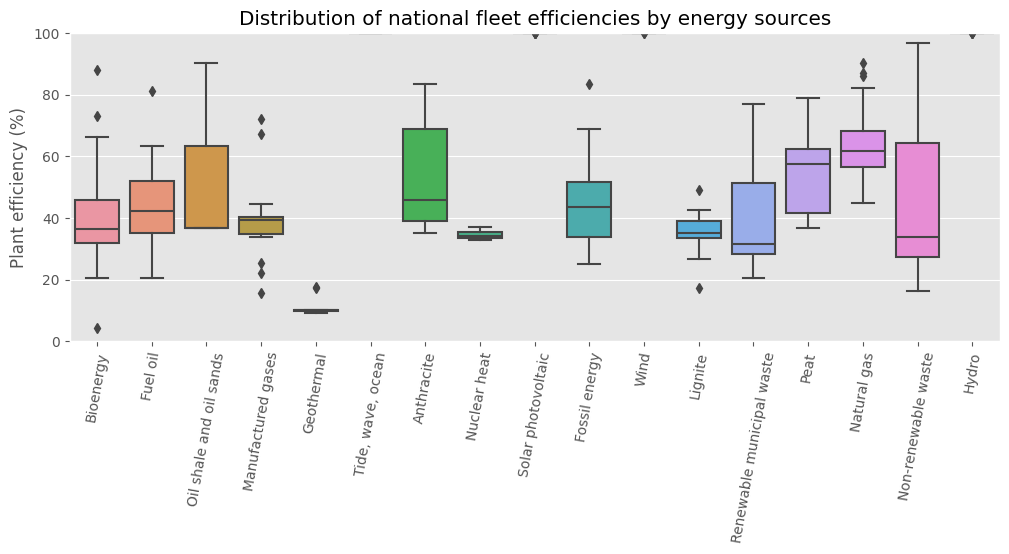

In [17]:
df = (
    ds_efficiency.ffill("DateTime")
    .isel(DateTime=-1)
    .drop("DateTime")
    .to_dataset("Energies")
    .to_dataframe()
    * 100
)
fig, ax = plt.subplots(figsize=(12, 4))
ax = sns.boxplot(df, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=80)
ax.set_ylim([0, 100])
ax.set_ylabel("Plant efficiency (%)")
plt.savefig("plot/distribution_efficiency.png", bbox_inches="tight")
ax.set_title("Distribution of national fleet efficiencies by energy sources")

### Exporting data

In [18]:
ds = xr.concat(
    [
        ds_efficiency.sel(Energies=energy_eurostat)
        for energy_enstoe, energy_eurostat in dict_energy_entsoe_to_eurostat.items()
    ],
    dim="Energies_ENTSOE",
)
ds = ds.assign_coords(
    coords={
        "Energies_ENTSOE": [
            energy_enstoe
            for energy_enstoe, energy_eurostat in dict_energy_entsoe_to_eurostat.items()
        ]
    }
)
ds = ds.rename({"Energies": "Energies_EUROSTAT"})
ds.to_netcdf("data/ds_efficiency_EUROSTAT.nc")
ds

<xarray.DataArray (Energies_ENTSOE: 21, Countries: 40, DateTime: 3)>
array([[[       nan,        nan,        nan],
        [0.45379373, 0.509126  , 0.48609078],
        [0.34404151, 0.2258568 , 0.23963022],
        ...,
        [0.34999239, 0.35072579, 0.33358793],
        [0.04174959,        nan,        nan],
        [       nan,        nan,        nan]],

       [[       nan,        nan,        nan],
        [       nan,        nan,        nan],
        [0.32383804, 0.32359991, 0.31469624],
        ...,
        [0.32698632, 0.32245924, 0.17341209],
        [       nan,        nan,        nan],
        [0.36027578, 0.36138837, 0.36233405]],

       [[       nan,        nan,        nan],
        [0.39942281, 0.39455394, 0.42385338],
        [0.24087635, 0.29396745, 0.39544359],
        ...,
...
        ...,
        [0.2560246 , 0.23299435, 0.2388671 ],
        [0.68308756,        nan,        nan],
        [       nan,        nan,        nan]],

       [[       nan,        nan,        nan],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        ...,
        [1.        , 1.        , 1.        ],
        [1.        ,        nan,        nan],
        [1.        , 1.        , 1.        ]],

       [[       nan,        nan,        nan],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        ...,
        [1.        , 1.        , 1.        ],
        [1.        ,        nan,        nan],
        [1.        , 1.        , 1.        ]]])
Coordinates:
    Energies_EUROSTAT  (Energies_ENTSOE) <U57 'Bioenergy' 'Lignite' ... 'Wind'
  * Countries          (Countries) <U9 'AL' 'AT' 'BA' 'BE' ... 'TR' 'UA' 'XK'
  * DateTime           (DateTime) datetime64[ns] 2020-01-01 ... 2022-01-01
  * Energies_ENTSOE    (Energies_ENTSOE) <U31 'Biomass' ... 'Wind Onshore'

## IEA data

### Loading data

- Data downloaded from using the script on github (not sure we can share those data)

In [19]:
# Importing data

list_dataset = os.listdir("data/IEA")
list_dataset = [ds.split(".")[0] for ds in list_dataset]
list_ds = []
for dataset in list_dataset:
    print(dataset)
    ds = xr.load_dataarray(f"data/IEA/{dataset}.nc")
    # display(ds)
    if dataset == "ELECTRICITYANDHEAT":
        ds = ds.rename({"flowLabel": "Energies", "productLabel": "nrg_bal"})
    else:
        ds = ds.rename({"productLabel": "Energies", "flowLabel": "nrg_bal"})
    if dataset == "RENEWABLES":
        df = ds.to_dataset("Energies").to_dataframe()
        df["Biofuels"] = df[
            ["Primary solid biofuels", "Liquid biofuels", "Biogases"]
        ].sum(axis=1)
        df["Waste"] = df[["Industrial waste", "Municipal waste"]].sum(axis=1)
        df.columns.name = "Energies"
        ds = df.stack().to_xarray()
    # display(ds)
    list_ds.append(ds)

# Merging data
ds = xr.concat(list_ds, dim="Energy_Group")
ds = ds.assign_coords(coords={"Energy_Group": list_dataset})

OIL
RENEWABLES
GAS
ELECTRICITYANDHEAT
COALANDPEAT
BALANCES


### Matching name

In [20]:
xr.load_dataarray(f"data/IEA/ELECTRICITYANDHEAT.nc").flowLabel.values

array(['Agriculture / forestry', 'Biofuels', 'Coal',
       'Commercial and public services', 'Domestic supply',
       'Electricity plants', 'Energy industry own use', 'Exports',
       'Final consumption', 'Fishing', 'Geothermal', 'Heat plants',
       'Hydro', 'Imports', 'Industry', 'Losses', 'Municipal Waste',
       'Natural gas', 'Nuclear', 'Oil', 'Other non-specified',
       'Other sources', 'Residential', 'Solar PV', 'Solar thermal',
       'Statistical differences', 'Tide', 'Total production',
       'Transformation', 'Transport', 'Waste', 'Waste (renewable)',
       'Wind'], dtype=object)

In [21]:
list_energies = [
    "Biofuels",
    "Coal",
    "Geothermal",
    "Hydro",
    "Natural gas",
    "Nuclear",
    "Oil",
    # "Other non-specified",
    # "Other sources",
    "Solar PV",
    "Tide",
    "Waste",
    "Wind",
]

In [22]:
def energy_matching_IEA(grid="Natural gas"):
    # Choose among energies for which we have electricity
    dict_energy_entsoe_to_IEA = {
        "Biomass": "Biofuels",
        "Fossil Brown coal/Lignite": "Coal",
        "Fossil Coal-derived gas": "Coal",
        "Fossil Gas": "Natural gas",
        "Fossil Hard coal": "Coal",
        "Fossil Oil": "Oil",
        "Fossil Oil shale": "Oil",
        "Fossil Peat": "Coal",
        "Geothermal": "Geothermal",
        "Grid": grid,
        "Hydro Pumped Storage": "Hydro",
        "Hydro Run-of-river and poundage": "Hydro",
        "Hydro Water Reservoir": "Hydro",
        "Marine": "Tide",
        "Nuclear": "Nuclear",
        "Other": "Oil",
        "Other renewable": "Solar PV",
        "Solar": "Solar PV",
        "Waste": "Waste",
        "Wind Offshore": "Wind",
        "Wind Onshore": "Wind",
    }
    return dict_energy_entsoe_to_IEA


dict_energy_entsoe_to_IEA = energy_matching_IEA()

In [23]:
from fuzzywuzzy import process

for energy_enstoe, energy_eurostat in dict_energy_entsoe_to_IEA.items():
    if energy_eurostat not in ds.Energies.values:
        print(energy_enstoe, energy_eurostat)
        print(process.extract(energy_enstoe, ds.productLabel.values))

### Calculation

In [24]:
# Energy input for electricity
ds_primary_energy_input = (
    xr.apply_ufunc(
        np.abs, ds.sel(nrg_bal=["Electricity plants", "CHP plants", "Heat plants"])
    )
    .sel(Energy_Group=["BALANCES", "RENEWABLES"])
    .sum(dim=["Energy_Group", "nrg_bal"])
    - ds.sel(nrg_bal="Heat", Energy_Group="ELECTRICITYANDHEAT") / 0.85
)
# Electricity output
ds_electricity_output = (
    ds.sel(nrg_bal="Electricity", Energy_Group="ELECTRICITYANDHEAT") * 3.6
)  # to convert GWh into TJ
ds_electricity_output = ds_electricity_output.where(ds_electricity_output > 0, np.nan)

# Efficiency
ds_efficiency = ds_electricity_output / ds_primary_energy_input

In [25]:
ds_efficiency.sel(Energies=list_energies, country="WORLD").drop(["country"]).to_dataset(
    "Energies"
).to_dataframe().tail()

C:\Users\romai\AppData\Local\Temp\ipykernel_2280\3778301790.py:1: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  ds_efficiency.sel(Energies=list_energies, country="WORLD").drop(["country"]).to_dataset(


,Biofuels,Coal,Geothermal,Hydro,Natural gas,Nuclear,Oil,Solar PV,Tide,Waste,Wind,Energy_Group
year,,,,,,,,,,,,
2018-01-01,0.311769,0.376173,0.102139,NaN,0.474510,0.330038,0.356110,NaN,NaN,0.295086,NaN,ELECTRICITYANDHEAT
2019-01-01,0.313018,0.374497,0.101891,NaN,0.477518,0.330022,0.352438,NaN,NaN,0.300624,NaN,ELECTRICITYANDHEAT
2020-01-01,0.311846,0.374942,0.100674,NaN,0.480045,0.330049,0.355851,NaN,NaN,0.309234,NaN,ELECTRICITYANDHEAT
2021-01-01,0.305933,0.373023,0.099964,NaN,0.477732,0.330050,0.356799,NaN,NaN,0.316240,NaN,ELECTRICITYANDHEAT
2022-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ELECTRICITYANDHEAT


C:\Users\romai\AppData\Local\Temp\ipykernel_2280\4272031051.py:3: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  .drop("country")
C:\Users\romai\AppData\Local\Temp\ipykernel_2280\4272031051.py:4: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  .drop("Energy_Group")


Text(0.5, 1.0, 'Evolution of power plant efficiency\n considering heat allocation*')

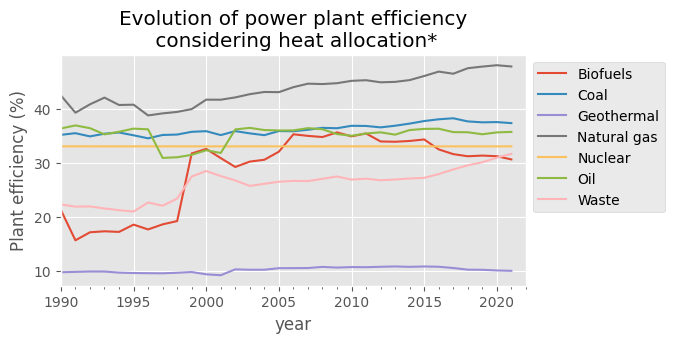

In [26]:
dfp = (
    ds_efficiency.sel(Energies=list_energies, country="WORLD")
    .drop("country")
    .drop("Energy_Group")
    .to_dataset("Energies")
    .to_dataframe()
)
dfp[dfp < 0] = 0
dfp = dfp.dropna(axis=1, how="all")
fig, ax = plt.subplots(figsize=(6, 3))
(dfp * 100).plot(ax=ax)
plt.legend(bbox_to_anchor=(1, 1))
ax.set_ylabel("Plant efficiency (%)")
ax.set_title("Evolution of power plant efficiency\n considering heat allocation*")

In [27]:
# Check values
energy = "Natural gas"
country = "FRA"
year = "2021"
print("Electricity output in TJ")
display(
    ds_electricity_output.sel(
        country=country, Energies=energy, year=year
    ).to_dataframe()
)
print("Energy input in TJ")
display(
    ds_primary_energy_input.sel(
        country=country, Energies=energy, year=year
    ).to_dataframe()
)
print("Efficiency")
display(ds_efficiency.sel(country=country, Energies=energy, year=year).to_dataframe())

Electricity output in TJ


,country,nrg_bal,Energies,Energy_Group,value
year,,,,,
2021-01-01,FRA,Electricity,Natural gas,ELECTRICITYANDHEAT,120078.0


Energy input in TJ


,country,Energies,nrg_bal,Energy_Group,value
year,,,,,
2021-01-01,FRA,Natural gas,Heat,ELECTRICITYANDHEAT,180838.823529


Efficiency


,country,Energies,Energy_Group,value
year,,,,
2021-01-01,FRA,Natural gas,ELECTRICITYANDHEAT,0.664006


### Visualisation

C:\Users\romai\AppData\Local\Temp\ipykernel_2280\171252790.py:7: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  .drop("year")
C:\Users\romai\AppData\Local\Temp\ipykernel_2280\171252790.py:8: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  .drop("Energy_Group")


Text(0.5, 1.0, 'Distribution of national fleet efficiencies by energy sources')

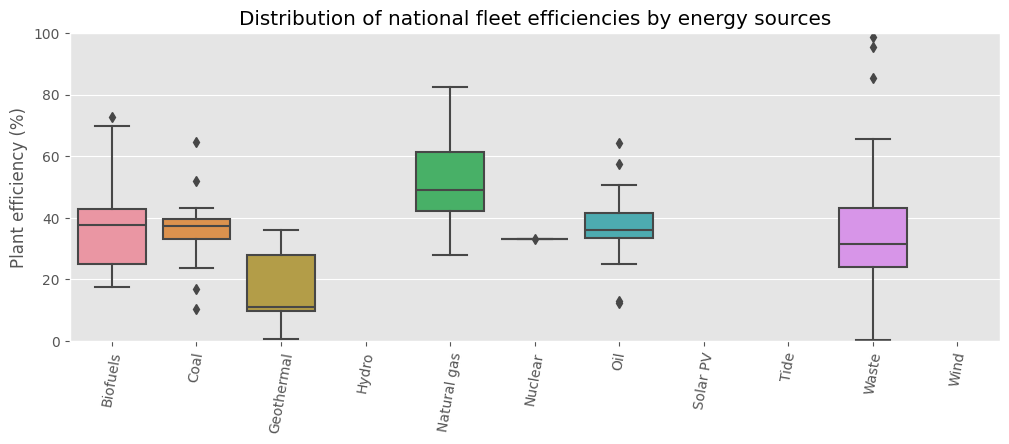

In [28]:
import seaborn as sns

df = (
    ds_efficiency.sel(Energies=list_energies)
    .ffill("year")
    .isel(year=-1)
    .drop("year")
    .drop("Energy_Group")
    .to_dataset("Energies")
    .to_dataframe()
    * 100
)
df[df < 0] = np.nan
fig, ax = plt.subplots(figsize=(12, 4))
ax = sns.boxplot(df, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=80)
ax.set_ylim([0, 100])
ax.set_ylabel("Plant efficiency (%)")
plt.savefig("plot/distribution_efficiency_IEA_data.png", bbox_inches="tight")
ax.set_title("Distribution of national fleet efficiencies by energy sources")

In [29]:
df.Geothermal.describe()

count     9.000000
mean     16.854310
std      13.033874
min       0.766437
25%       9.623196
50%      10.996718
75%      28.104196
max      35.955897
Name: Geothermal, dtype: float64

In [30]:
df[df["Natural gas"] > 100]

,Biofuels,Coal,Geothermal,Hydro,Natural gas,Nuclear,Oil,Solar PV,Tide,Waste,Wind
country,,,,,,,,,,,
KGZ,NaN,51.981626,NaN,NaN,105.506283,NaN,50.284569,NaN,NaN,NaN,NaN


### Exporting data

In [31]:
ds = xr.concat(
    [
        ds_efficiency.sel(Energies=energy_IEA)
        for energy_enstoe, energy_IEA in dict_energy_entsoe_to_IEA.items()
    ],
    dim="Energies_ENTSOE",
)
ds = ds.assign_coords(
    coords={
        "Energies_ENTSOE": [
            energy_enstoe
            for energy_enstoe, energy_IEA in dict_energy_entsoe_to_IEA.items()
        ]
    }
)
ds = ds.rename({"Energies": "Energies_IEA"})
ds.to_netcdf("data/ds_efficiency_IEA.nc")
ds

<xarray.DataArray 'value' (Energies_ENTSOE: 21, year: 33, country: 175)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * country          (country) object 'AFRICA' 'AGO' 'ALB' ... 'ZAF' 'ZMB' 'ZWE'
  * year             (year) datetime64[ns] 1990-01-01 1991-01-01 ... 2022-01-01
    Energies_IEA     (Energies_ENTSOE) <U11 'Biofuels' 'Coal' ... 'Wind' 'Wind'
    Energy_Group     <U18 'ELECTRICITYANDHEAT'
  * Energies_ENTSOE  (Energies_ENTSOE) <U31 'Biomass' ... 'Wind Onshore'

# Merge efficiency data

In [32]:
ds_efficiency = xr.load_dataarray("data/ds_efficiency_EUROSTAT.nc")
ds_efficiency = ds_efficiency.drop("Energies_EUROSTAT")
ds_efficiency = ds_efficiency.rename({"Energies_ENTSOE": "Energies"})
ds_efficiency = ds_efficiency.rename({"Countries": "Production_Countries"})
# ds_efficiency = ds_efficiency.mean(dim="DateTime")
ds_efficiency = ds_efficiency.ffill("DateTime").isel(DateTime=-1).drop("DateTime")
df_efficiency_eurostat = ds_efficiency.to_dataset("Energies").to_dataframe()
df_efficiency_eurostat.head()

C:\Users\romai\AppData\Local\Temp\ipykernel_2280\2908724055.py:2: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  ds_efficiency = ds_efficiency.drop("Energies_EUROSTAT")
C:\Users\romai\AppData\Local\Temp\ipykernel_2280\2908724055.py:6: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  ds_efficiency = ds_efficiency.ffill("DateTime").isel(DateTime=-1).drop("DateTime")


,Biomass,Fossil Brown coal/Lignite,Fossil Coal-derived gas,Fossil Gas,Fossil Hard coal,Fossil Oil,Fossil Oil shale,Fossil Peat,Geothermal,Grid,...,Hydro Run-of-river and poundage,Hydro Water Reservoir,Marine,Nuclear,Other,Other renewable,Solar,Waste,Wind Offshore,Wind Onshore
Production_Countries,,,,,,,,,,,,,,,,,,,,,
AL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
AT,0.486091,NaN,0.423853,0.678532,NaN,0.535728,NaN,NaN,0.1,0.678532,...,1.0,1.0,NaN,NaN,0.561371,0.298668,1.0,0.343934,1.0,1.0
BA,0.239630,0.314696,0.395444,1.859753,NaN,0.373355,NaN,NaN,NaN,1.859753,...,1.0,1.0,NaN,NaN,0.292059,NaN,1.0,NaN,1.0,1.0
BE,0.368412,NaN,0.419568,0.630202,NaN,0.813099,NaN,NaN,-inf,0.630202,...,1.0,1.0,NaN,0.352690,0.520599,0.242915,1.0,0.254869,1.0,1.0
BG,0.361882,0.337279,NaN,0.901765,0.762376,0.204046,0.904144,NaN,NaN,0.901765,...,1.0,1.0,NaN,0.333354,0.322657,0.328270,1.0,0.663398,1.0,1.0


In [33]:
ds_efficiency = xr.load_dataarray("data/ds_efficiency_IEA.nc")
ds_efficiency = ds_efficiency.drop("Energy_Group").drop("Energies_IEA")
ds_efficiency = ds_efficiency.ffill("year").isel(year=-1).drop("year")
ds_efficiency = ds_efficiency.rename({"Energies_ENTSOE": "Energies"})
ds_efficiency = ds_efficiency.rename({"country": "Production_Countries"})
df_efficiency_IEA = ds_efficiency.to_dataset("Energies").to_dataframe()
df_efficiency_IEA.head()

C:\Users\romai\AppData\Local\Temp\ipykernel_2280\2560555568.py:2: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  ds_efficiency = ds_efficiency.drop("Energy_Group").drop("Energies_IEA")
C:\Users\romai\AppData\Local\Temp\ipykernel_2280\2560555568.py:3: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  ds_efficiency = ds_efficiency.ffill("year").isel(year=-1).drop("year")


,Biomass,Fossil Brown coal/Lignite,Fossil Coal-derived gas,Fossil Gas,Fossil Hard coal,Fossil Oil,Fossil Oil shale,Fossil Peat,Geothermal,Grid,...,Hydro Run-of-river and poundage,Hydro Water Reservoir,Marine,Nuclear,Other,Other renewable,Solar,Waste,Wind Offshore,Wind Onshore
Production_Countries,,,,,,,,,,,,,,,,,,,,,
AFRICA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AGO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ALB,NaN,NaN,NaN,NaN,NaN,0.264687,0.264687,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.264687,NaN,NaN,NaN,NaN,NaN
ARE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ARG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
# List ENTSOE countries
list_countries = [
    "AL",
    "AM",
    "AT",
    "AZ",
    "BA",
    "BE",
    "BG",
    "BY",
    "CH",
    "CZ",
    "DE",
    "DK",
    "EE",
    "ES",
    "FI",
    "FR",
    "GB",
    "GE",
    "GR",
    "HR",
    "HU",
    "IE",
    "IT",
    "LT",
    "LU",
    "LV",
    "MD",
    "ME",
    "MK",
    "MT",
    "NL",
    "NO",
    "PL",
    "PT",
    "RO",
    "RS",
    "RU",
    "SE",
    "SI",
    "SK",
    "TR",
    "UA",
    "XK",
]

In [35]:
import pycountry


def convert_to_ISO2(country):
    if country == "UNK":
        country = "XK"
    if len(country) == 3:
        country = pycountry.countries.get(alpha_3=country).alpha_2
    return country


df_efficiency_IEA.index = [
    convert_to_ISO2(country) for country in df_efficiency_IEA.index
]
df_efficiency_IEA.head()

,Biomass,Fossil Brown coal/Lignite,Fossil Coal-derived gas,Fossil Gas,Fossil Hard coal,Fossil Oil,Fossil Oil shale,Fossil Peat,Geothermal,Grid,...,Hydro Run-of-river and poundage,Hydro Water Reservoir,Marine,Nuclear,Other,Other renewable,Solar,Waste,Wind Offshore,Wind Onshore
AFRICA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AL,NaN,NaN,NaN,NaN,NaN,0.264687,0.264687,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.264687,NaN,NaN,NaN,NaN,NaN
AE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
# Completing the EUROSTAT data with IEA data when data are missing
df_efficiency = df_efficiency_eurostat.combine_first(df_efficiency_IEA)
df_efficiency[df_efficiency < 0] = np.nan
df_efficiency.columns.name = "Energies"
df_efficiency.index.name = "Production_Countries"
ds_efficiency = df_efficiency.stack().to_xarray()
ds_efficiency.to_netcdf("data/ds_efficiency_combined.nc")
ds_efficiency

<xarray.DataArray (Production_Countries: 69, Energies: 21)>
array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [0.17635524, 0.34984181, 0.34984181, ..., 0.22309817,        nan,
               nan],
       ...,
       [0.37561643, 0.37081165, 0.37081165, ..., 0.2398473 ,        nan,
               nan],
       [0.30593348, 0.37302278, 0.37302278, ..., 0.31624013,        nan,
               nan],
       [       nan, 0.36233405,        nan, ...,        nan, 1.        ,
        1.        ]])
Coordinates:
  * Production_Countries  (Production_Countries) object 'AL' 'AM' ... 'XK'
  * Energies              (Energies) object 'Biomass' ... 'Wind Onshore'

In [37]:
def fill_efficiency_missing_data(self, ds, filling_quantile=0.10):
    # Missing countries
    list_missing_countries = list(
        set(self.ds_consumption_tracked.Production_Countries.values)
        - set(ds.Production_Countries.values)
    )
    print("Missing countries:")
    print(list_missing_countries)
    df = ds.to_dataset("Energies").to_dataframe()
    # Removing negative values due to missing data
    df[df < 0] = np.nan
    # Add missing countries
    df_missing = pd.DataFrame(columns=df.columns, index=list_missing_countries)
    df_missing.index.name = df.index.name
    df = pd.concat([df, df_missing])
    df.columns.name = "Energies"
    df = df.fillna(df.quantile(filling_quantile))
    ds = df.unstack().to_xarray()
    ds = ds.sel(
        Production_Countries=self.ds_consumption_tracked.Production_Countries.values
    )
    return ds


def get_efficiency_data(self, filling_quantile=0.1):
    """Return the efficiency dataset based on EUROSTAT data"""
    ds_efficiency = xr.load_dataarray("data/ds_efficiency.nc")
    ds_efficiency = ds_efficiency.drop("Energies_EUROSTAT")
    ds_efficiency = ds_efficiency.rename({"Energies_ENTSOE": "Energies"})
    ds_efficiency = ds_efficiency.rename({"Countries": "Production_Countries"})
    ds_efficiency = ds_efficiency.mean(dim="DateTime")
    ds_efficiency = self.fill_efficiency_missing_data(
        ds=ds_efficiency, filling_quantile=filling_quantile
    )
    return ds_efficiency

# Emissions factor

In [38]:
# Importing data from emission_factors_energy_products
df_fuels = pd.read_csv(
    "data/emission_factors_energy_products.csv",
    header=[0, 1],
    index_col=1,
    delimiter=";",
)
df_fuels.head()

upstream emissions: JECv5, combustion emissions: IPCC 2006, Guidelines for National Greenhouse Gas Inventories Source: Eurostat  \
label                                                                                                                      siec   
Solid fossil fuels                                                                                              C0000X0350-0370   
Anthracite                                                                                                                C0110   
Coking coal                                                                                                               C0121   
Other bituminous coal                                                                                                     C0129   
Sub-bituminous coal                                                                                                       C0210   

upstream emissions: JECv5, combustion emissions: IPCC 2006, Guidelines for National Greenhouse Gas Inventories  kg/TJ  \
label                                                                                                           efCO2   
Solid fossil fuels                                                                                              94600   
Anthracite                                                                                                      98300   
Coking coal                                                                                                     94600   
Other bituminous coal                                                                                           94600   
Sub-bituminous coal                                                                                             96100   

upstream emissions: JECv5, combustion emissions: IPCC 2006, Guidelines for National Greenhouse Gas Inventories        \
label                                                                                                          efCH4   
Solid fossil fuels                                                                                                 1   
Anthracite                                                                                                         1   
Coking coal                                                                                                        1   
Other bituminous coal                                                                                              1   
Sub-bituminous coal                                                                                                1   

upstream emissions: JECv5, combustion emissions: IPCC 2006, Guidelines for National Greenhouse Gas Inventories        \
label                                                                                                          efN2O   
Solid fossil fuels                                                                                               1.5   
Anthracite                                                                                                       1.5   
Coking coal                                                                                                      1.5   
Other bituminous coal                                                                                            1.5   
Sub-bituminous coal                                                                                              1.5   

upstream emissions: JECv5, combustion emissions: IPCC 2006, Guidelines for National Greenhouse Gas Inventories kg CO2eq / TJ  
label                                                                                                             UpstreamE3  
Solid fossil fuels                                                                                                      1700  
Anthracite                                                                                                             16000  
Coking coal                                 

In [39]:
# Extracting emmission factor
df_ef = df_fuels["kg/TJ"]
df_ef.head()
df_ef.columns = [col.replace("ef", "") for col in df_ef.columns]
df_ef.head()

,CO2,CH4,N2O
Solid fossil fuels,94600,1,1.5
Anthracite,98300,1,1.5
Coking coal,94600,1,1.5
Other bituminous coal,94600,1,1.5
Sub-bituminous coal,96100,1,1.5


In [40]:
# Calculating the equivalent carbon footprint
GWP_factors = {"CO2": 1, "CH4": 25, "N2O": 298}
df_ef_CO2eq = df_ef.multiply(GWP_factors)
df_ef_CO2eq["Total"] = df_ef_CO2eq.sum(axis=1)

# Concatenating all data together
df_ef_CO2eq = pd.concat([df_ef_CO2eq], axis=1, keys=["kg CO2eq / TJ (combustion)"])
df_fuels = pd.concat([df_fuels, df_ef_CO2eq], axis=1)
df_fuels.head()

upstream emissions: JECv5, combustion emissions: IPCC 2006, Guidelines for National Greenhouse Gas Inventories Source: Eurostat  \
label                                                                                                                      siec   
Solid fossil fuels                                                                                              C0000X0350-0370   
Anthracite                                                                                                                C0110   
Coking coal                                                                                                               C0121   
Other bituminous coal                                                                                                     C0129   
Sub-bituminous coal                                                                                                       C0210   

upstream emissions: JECv5, combustion emissions: IPCC 2006, Guidelines for National Greenhouse Gas Inventories  kg/TJ  \
label                                                                                                           efCO2   
Solid fossil fuels                                                                                              94600   
Anthracite                                                                                                      98300   
Coking coal                                                                                                     94600   
Other bituminous coal                                                                                           94600   
Sub-bituminous coal                                                                                             96100   

upstream emissions: JECv5, combustion emissions: IPCC 2006, Guidelines for National Greenhouse Gas Inventories        \
label                                                                                                          efCH4   
Solid fossil fuels                                                                                                 1   
Anthracite                                                                                                         1   
Coking coal                                                                                                        1   
Other bituminous coal                                                                                              1   
Sub-bituminous coal                                                                                                1   

upstream emissions: JECv5, combustion emissions: IPCC 2006, Guidelines for National Greenhouse Gas Inventories        \
label                                                                                                          efN2O   
Solid fossil fuels                                                                                               1.5   
Anthracite                                                                                                       1.5   
Coking coal                                                                                                      1.5   
Other bituminous coal                                                                                            1.5   
Sub-bituminous coal                                                                                              1.5   

upstream emissions: JECv5, combustion emissions: IPCC 2006, Guidelines for National Greenhouse Gas Inventories kg CO2eq / TJ  \
label                                                                                                             UpstreamE3   
Solid fossil fuels                                                                                                      1700   
Anthracite                                                                                                             16000   
Coking coal                             

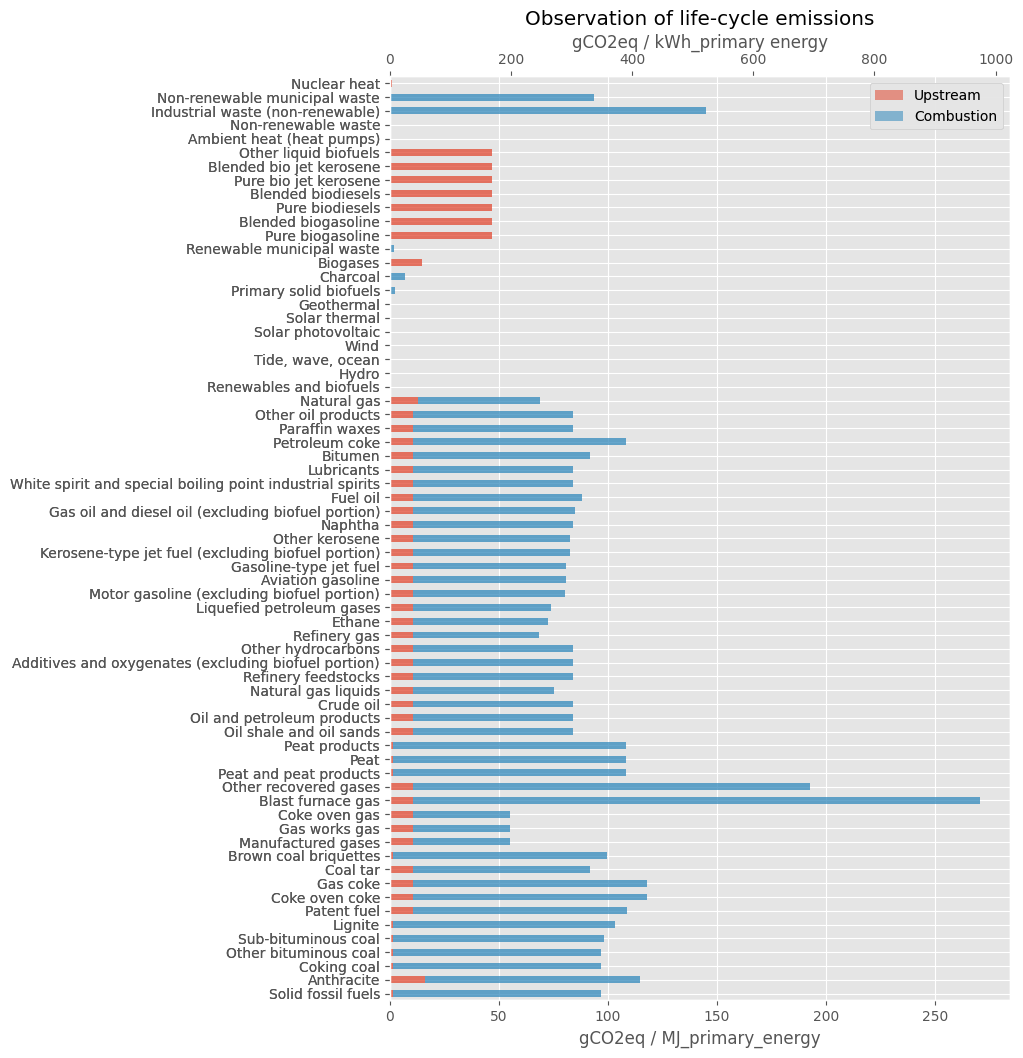

In [41]:
dfp = pd.DataFrame()
dfp["Upstream"] = df_fuels["kg CO2eq / TJ"]["UpstreamE3"]
dfp["Combustion"] = df_fuels["kg CO2eq / TJ (combustion)"]["Total"]

fig, ax = plt.subplots(figsize=(8, 12))
ax2 = ax.twiny()
(dfp * 1e3 / 1e6).plot(ax=ax, kind="barh", stacked=True, alpha=0.5)
(dfp / 1e6 * 3.6 * 1e3).plot(ax=ax2, kind="barh", stacked=True, alpha=0.5)
ax.set_title("Observation of life-cycle emissions")
ax.set_xlabel("gCO2eq / MJ_primary_energy")
ax2.set_xlabel("gCO2eq / kWh_primary energy")
ax2.grid(False)

In [42]:
df = dfp / 1e6 * 3.6 * 1e3
df.loc["Fossil energy"] = df.loc["Fuel oil"]
df.loc["Bioenergy"] = df.loc["Biogases"]

df.index.name = "Energies_EUROSTAT"
df.columns.name = "Emission_phase"
ds_EF = df.unstack().to_xarray()
ds_EF

<xarray.DataArray (Emission_phase: 2, Energies_EUROSTAT: 69)>
array([[6.1200000e+00, 5.7600000e+01, 6.1200000e+00, 6.1200000e+00,
        6.1200000e+00, 6.1200000e+00, 3.8520000e+01, 3.8520000e+01,
        3.8520000e+01, 3.8520000e+01, 6.1200000e+00, 3.8520000e+01,
        3.8520000e+01, 3.8520000e+01, 3.8520000e+01, 3.8520000e+01,
        6.1200000e+00, 6.1200000e+00, 6.1200000e+00, 3.8520000e+01,
        3.8520000e+01, 3.8520000e+01, 3.8520000e+01, 3.8520000e+01,
        3.8520000e+01, 3.8520000e+01, 3.8520000e+01, 3.8520000e+01,
        3.8520000e+01, 3.8520000e+01, 3.8520000e+01, 3.8520000e+01,
        3.8520000e+01, 3.8520000e+01, 3.8520000e+01, 3.8520000e+01,
        3.8520000e+01, 3.8520000e+01, 3.8520000e+01, 3.8520000e+01,
        3.8520000e+01, 3.8520000e+01, 3.8520000e+01, 4.6080000e+01,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 2.5200000e+00,
        2.5200000e+00, 5.3640000e+01, 0.0000000e+00, 1.6848000e+02,
        1.6848000e+02, 1.6848000e+02, 1.6848000e+02, 1.6848000e+02,
        1.6848000e+02, 1.6848000e+02, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 4.3200000e+00, 3.8520000e+01,
        5.3640000e+01],
       [3.4225920e+02, 3.5557920e+02, 3.4225920e+02, 3.4225920e+02,
        3.4765920e+02, 3.6529920e+02, 3.5269920e+02, 3.8689920e+02,
        3.8539728e+02, 2.9221920e+02, 3.5269920e+02, 1.6003728e+02,
        1.6003728e+02, 1.6003728e+02, 9.3619728e+02, 6.5539728e+02,
        3.8329920e+02, 3.8329920e+02, 3.8329920e+02, 2.6479368e+02,
        2.6479368e+02, 2.6479368e+02, 2.3203368e+02, 2.6479368e+02,
        2.6479368e+02, 2.6479368e+02, 2.0755728e+02, 2.2195728e+02,
        2.2735728e+02, 2.5039368e+02, 2.5291368e+02, 2.5291368e+02,
        2.5831368e+02, 2.5831368e+02, 2.6479368e+02, 2.6767368e+02,
        2.7955368e+02, 2.6479368e+02, 2.6479368e+02, 2.9143368e+02,
        3.5191368e+02, 2.6479368e+02, 2.6479368e+02, 2.0215728e+02,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 6.9912000e+00,
        2.2291200e+01, 1.9728000e-01, 6.9912000e+00, 9.1368000e-01,
        9.1368000e-01, 9.1368000e-01, 9.1368000e-01, 9.1368000e-01,
        9.1368000e-01, 9.1368000e-01, 0.0000000e+00, 0.0000000e+00,
        5.2179120e+02, 3.3711120e+02, 0.0000000e+00, 2.7955368e+02,
        1.9728000e-01]])
Coordinates:
  * Emission_phase     (Emission_phase) object 'Upstream' 'Combustion'
  * Energies_EUROSTAT  (Energies_EUROSTAT) object 'Solid fossil fuels' ... 'B...

In [43]:
ds = xr.concat(
    [
        ds_EF.sel(Energies_EUROSTAT=energy_eurostat)
        for energy_enstoe, energy_eurostat in dict_energy_entsoe_to_eurostat.items()
    ],
    dim="Energies_ENTSOE",
)
ds = ds.assign_coords(
    coords={
        "Energies_ENTSOE": [
            energy_enstoe
            for energy_enstoe, energy_eurostat in dict_energy_entsoe_to_eurostat.items()
        ]
    }
)
ds.to_netcdf("data/ds_emissions_factors.nc")

In [44]:
ds

<xarray.DataArray (Energies_ENTSOE: 21, Emission_phase: 2)>
array([[5.3640000e+01, 1.9728000e-01],
       [6.1200000e+00, 3.6529920e+02],
       [3.8520000e+01, 1.6003728e+02],
       [4.6080000e+01, 2.0215728e+02],
       [5.7600000e+01, 3.5557920e+02],
       [3.8520000e+01, 2.7955368e+02],
       [3.8520000e+01, 2.6479368e+02],
       [6.1200000e+00, 3.8329920e+02],
       [0.0000000e+00, 0.0000000e+00],
       [4.6080000e+01, 2.0215728e+02],
       [0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00],
       [4.3200000e+00, 0.0000000e+00],
       [3.8520000e+01, 2.7955368e+02],
       [0.0000000e+00, 6.9912000e+00],
       [0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00]])
Coordinates:
  * Emission_phase     (Emission_phase) object 'Upstream' 'Combustion'
    Energies_EUROSTAT  (Energies_ENTSOE) <U25 'Bioenergy' 'Lignite' ... 'Wind'
  * Energies_ENTSOE    (Energies_ENTSOE) <U31 'Biomass' ... 'Wind Onshore'

# Losses

In [45]:
# list_nrg_values = eurostat.get_par_values(dataset_code, "nrg_bal")
list_loss_values = ["LOSS", "TL", "TRANSL", "DL", "DL_NT", "TRANSL_DL"]

In [46]:
for col in list_loss_values:
    print(f"{col}: {dict_nrg_bal[col]}")

LOSS: Losses
TL: Transformation losses
TRANSL: Transmission losses
DL: Distribution losses
DL_NT: Distribution losses - non-technical
TRANSL_DL: Transmission and distribution losses


In [47]:
def get_eurostat_loss_data(year_start=2020, year_end=2023, force=False):
    """Return a xarray dataset in GWh"""
    file = f"data/ds_eurostat_loss.nc"
    if not os.path.exists(file) or force:
        print("Downloading data, it takes a while, be patient.")
        filter_pars = {
            "freq": "A",
            "unit": "GWH",
            "startPeriod": year_start,
            "endPeriod": year_end,
            "nrg_bal": ["NEP", "LOSS", "DL", "DL_NT", "TRANSL"],
        }
        df = eurostat.get_data_df("nrg_cb_e", filter_pars=filter_pars)
        # df = df[["nrg_bal", "siec", "geo\TIME_PERIOD", f"{year}"]]
        df = df.drop(["freq", "unit"], axis=1)
        df = df.rename(columns={"siec": "Energies", "geo\TIME_PERIOD": "Countries"})
        df = df.pivot_table(columns=["nrg_bal", "Energies", "Countries"])
        df.index = pd.to_datetime(df.index)
        df.index.name = "DateTime"
        df = df.rename(
            columns=dict_siec, level=1
        )  # .rename(columns=dict_nrg_bal, level=0)
        ds = df.unstack().to_xarray()
        ds = ds / ds.sel(nrg_bal="NEP")
        ds = ds.sel(Energies="Electricity")
        ds.to_netcdf(file)
    ds = xr.load_dataarray(file)
    return ds

In [48]:
ds = get_eurostat_loss_data(year_start=2020, year_end=2023, force=False)
ds

<xarray.DataArray (nrg_bal: 5, Countries: 42, DateTime: 4)>
array([[[           nan,            nan, 1.23958054e-01, 1.26959421e-01],
        [0.00000000e+00, 0.00000000e+00, 3.50916909e-02, 4.35130092e-02],
        [7.86746834e-02, 7.67548907e-02, 6.11775529e-02,            nan],
        [           nan,            nan, 2.72810511e-02, 3.97382308e-02],
        [0.00000000e+00, 0.00000000e+00, 3.55499059e-02, 6.45432554e-02],
        [5.15590658e-02,            nan, 1.80405807e-02, 3.17639886e-02],
        [0.00000000e+00, 0.00000000e+00, 3.07209139e-02, 4.23801577e-02],
        [           nan, 0.00000000e+00, 3.02267824e-02, 5.20906807e-02],
        [4.65740519e-02, 2.97090093e-02, 2.73765590e-02, 5.51652748e-02],
        [1.34225540e-02, 1.54280389e-02, 4.68064358e-02, 6.54492273e-02],
        [           nan, 9.90574835e-02, 1.05396458e-01, 2.24948875e-01],
        [0.00000000e+00, 0.00000000e+00, 8.53348073e-02, 1.14865696e-01],
        [           nan,            nan, 7.21323285e-02, 8.87308260e-02],
        [1.12318272e-02, 1.25704931e-02, 4.58185878e-02, 6.50926701e-02],
        [           nan, 2.69318985e-02, 1.92068676e-02, 3.44998854e-02],
        [4.94158792e-02, 5.26231507e-02, 5.53515607e-02, 7.07235323e-02],
        [8.11188683e-02, 7.17129872e-02, 5.48247809e-02, 8.14380667e-02],
        [           nan,            nan, 8.73368184e-02, 1.08322925e-01],
        [           nan, 0.00000000e+00, 6.89688651e-02, 7.34674500e-02],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 8.08520719e-02],
...
        [           nan,            nan, 0.00000000e+00,            nan],
        [           nan,            nan, 7.70513676e-02,            nan],
        [           nan, 0.00000000e+00, 1.43254084e-02,            nan],
        [0.00000000e+00, 0.00000000e+00, 2.24378839e-02,            nan],
        [           nan,            nan, 1.82227222e-01,            nan],
        [           nan,            nan, 4.42150431e-02,            nan],
        [0.00000000e+00, 0.00000000e+00, 2.06182447e-02,            nan],
        [           nan, 0.00000000e+00, 0.00000000e+00,            nan],
        [1.06065252e-02, 1.15736195e-02, 1.15708885e-02,            nan],
        [0.00000000e+00, 0.00000000e+00, 1.45851540e-02,            nan],
        [           nan, 0.00000000e+00, 1.09825214e-02,            nan],
        [           nan,            nan, 1.66110552e-02,            nan],
        [           nan,            nan, 0.00000000e+00,            nan],
        [0.00000000e+00, 0.00000000e+00, 2.44309835e-02,            nan],
        [0.00000000e+00, 0.00000000e+00, 2.91830396e-02,            nan],
        [           nan,            nan, 2.82740379e-02,            nan],
        [0.00000000e+00, 0.00000000e+00, 1.35836009e-02,            nan],
        [           nan,            nan, 1.73115205e-02,            nan],
        [           nan,            nan,            nan,            nan],
        [           nan,            nan,            nan,            nan]]])
Coordinates:
  * nrg_bal    (nrg_bal) <U6 'DL' 'DL_NT' 'LOSS' 'NEP' 'TRANSL'
    Energies   <U11 'Electricity'
  * Countries  (Countries) <U9 'AL' 'AT' 'BA' 'BE' 'BG' ... 'SK' 'TR' 'UA' 'XK'
  * DateTime   (DateTime) datetime64[ns] 2020-01-01 2021-01-01 ... 2023-01-01

In [49]:
ds.sel(nrg_bal="TRANSL").ffill("DateTime").isel(DateTime=-1).to_dataframe("gl")

,nrg_bal,Energies,DateTime,gl
Countries,,,,
AL,TRANSL,Electricity,2023-01-01,0.013496
AT,TRANSL,Electricity,2023-01-01,0.013198
BA,TRANSL,Electricity,2023-01-01,0.021882
BE,TRANSL,Electricity,2023-01-01,0.009086
BG,TRANSL,Electricity,2023-01-01,0.019077
CY,TRANSL,Electricity,2023-01-01,0.010577
CZ,TRANSL,Electricity,2023-01-01,0.012943
DE,TRANSL,Electricity,2023-01-01,0.017450
DK,TRANSL,Electricity,2023-01-01,0.026644


## Plot of grid lossess

In [50]:
from ecodynelec.statistics_LF import *

df = (
    ds.sel(nrg_bal="TRANSL", DateTime="2022")
    .drop_vars(["nrg_bal", "Energies", "DateTime"])
    .to_dataframe("grid_losses")
)
df = df.droplevel(1, 0)
gdf = get_geodraframe(df * 100)

In [51]:
gdf.head()

,grid_losses,geometry
Countries,,
HU,1.334977,"POLYGON ((5214660.069 2880853.832, 5216710.220..."
FR,2.205370,"MULTIPOLYGON (((9954236.116 -3059379.316, 9961..."
IE,0.000000,"MULTIPOLYGON (((3230329.820 3682748.467, 31996..."
BE,0.908574,"POLYGON ((3957506.818 3167694.476, 3964175.126..."
CZ,1.294286,"POLYGON ((4645979.160 3093185.023, 4656689.778..."


(2000000.0, 6000000.0, 1400000.0, 5000000.0)

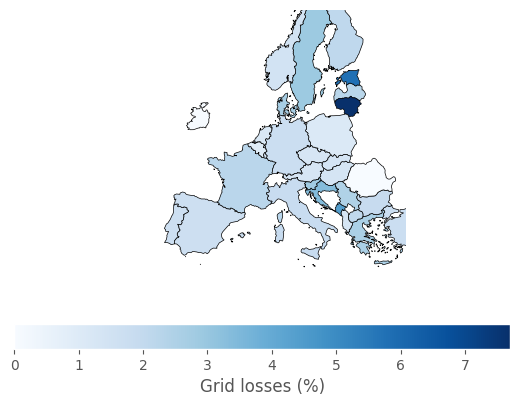

In [52]:
fig, ax = plt.subplots()
gdf.plot(
    "grid_losses",
    ax=ax,
    cmap="Blues",
    edgecolor="k",
    legend=True,
    # vmin=0,
    # vmax=1,
    legend_kwds={
        "location": "bottom",
        "label": "Grid losses (%)",
    },
)
ax.set_xlim([2e6, 6e6])
ax.set_ylim([1.4e6, 5e6])

ax.grid(False)
ax.axis("off")

In [53]:
df.describe()

,grid_losses
count,39.000000
mean,0.024177
std,0.029779
min,0.000000
25%,0.013274
50%,0.017874
75%,0.025075
max,0.182227


,DL,DL_NT,LOSS,NEP,TRANSL,Energies,Countries
DateTime,,,,,,,
2020-01-01,NaN,NaN,0.063928,1.0,NaN,Electricity,IT
2021-01-01,0.000000,0.0,0.067960,1.0,0.000000,Electricity,IT
2022-01-01,0.051286,0.0,0.069740,1.0,0.018455,Electricity,IT
2023-01-01,0.068844,NaN,NaN,1.0,NaN,Electricity,IT


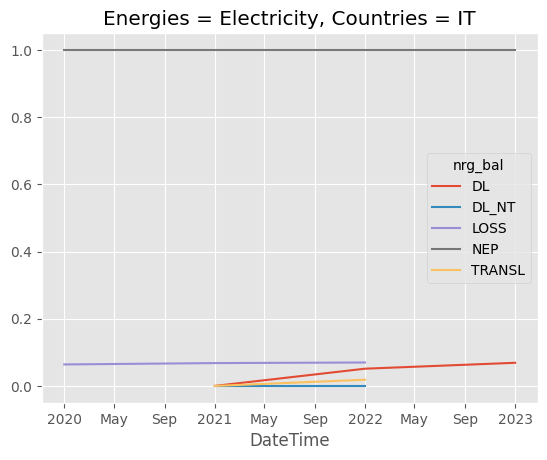

In [54]:
country = "IT"
ds.sel(Countries=country).plot(hue="nrg_bal")
ds.sel(Countries=country).to_dataset("nrg_bal").to_dataframe()

In [55]:
df = (
    ds.sel(DateTime="2022")
    .drop_vars(["Energies", "DateTime"])
    .to_dataset("nrg_bal")
    .to_dataframe()
)
df = df.droplevel(1, 0)
gdf = get_geodraframe(df * 100)
gdf.head()

,DL,DL_NT,LOSS,NEP,TRANSL,geometry
Countries,,,,,,
HU,6.896887,0.0,8.231863,100.0,1.334977,"POLYGON ((5214660.069 2880853.832, 5216710.220..."
FR,5.535156,0.0,7.740526,100.0,2.205370,"MULTIPOLYGON (((9954236.116 -3059379.316, 9961..."
IE,0.000000,0.0,7.454107,100.0,0.000000,"MULTIPOLYGON (((3230329.820 3682748.467, 31996..."
BE,2.728105,0.0,3.636679,100.0,0.908574,"POLYGON ((3957506.818 3167694.476, 3964175.126..."
CZ,3.072091,0.0,4.366377,100.0,1.294286,"POLYGON ((4645979.160 3093185.023, 4656689.778..."


In [56]:
# Almost no data for non technical distribution losses (i.e. thief)
gdf.DL_NT.replace(0, np.nan).dropna()

Countries
PT    0.244183
EL    3.845202
Name: DL_NT, dtype: float64

(1400000.0, 5000000.0)

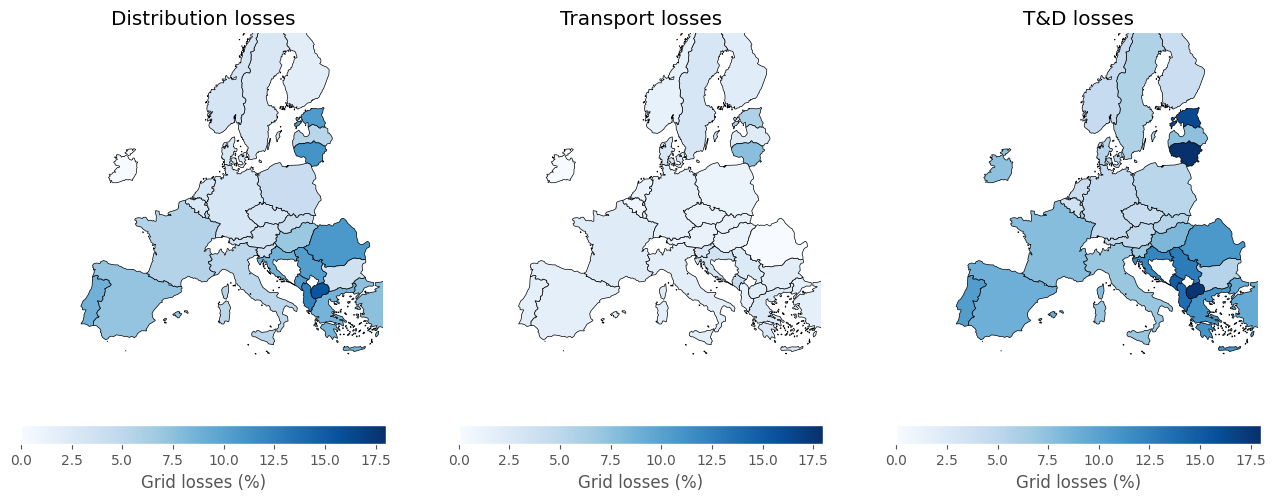

In [57]:
fig, ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(16, 6))
gdf.plot(
    "DL",
    ax=ax[0],
    cmap="Blues",
    edgecolor="k",
    legend=True,
    vmin=0,
    vmax=18,
    legend_kwds={
        "location": "bottom",
        "label": "Grid losses (%)",
    },
)
ax[0].grid(False)
ax[0].axis("off")
ax[0].set_title("Distribution losses")

gdf.plot(
    "TRANSL",
    ax=ax[1],
    cmap="Blues",
    edgecolor="k",
    legend=True,
    vmin=0,
    vmax=18,
    legend_kwds={
        "location": "bottom",
        "label": "Grid losses (%)",
    },
)
ax[1].grid(False)
ax[1].axis("off")
ax[1].set_title("Transport losses")

gdf.plot(
    "LOSS",
    ax=ax[2],
    cmap="Blues",
    edgecolor="k",
    legend=True,
    vmin=0,
    vmax=18,
    legend_kwds={
        "location": "bottom",
        "label": "Grid losses (%)",
    },
)
ax[2].grid(False)
ax[2].axis("off")
ax[2].set_title("T&D losses")

ax[0].set_xlim([2e6, 6e6])
ax[0].set_ylim([1.4e6, 5e6])